# Fashion items classification with Pytorch and transfer learning

![Test Image 4](https://635.gtbank.com/wp-content/uploads/2017/09/Must-have.jpg)


In this project we will use [Kaggle's fashion items dataset](www.kaggle.com) and retrain a ResNet18 architecture model using two transfer learning techniques and choosing the best performing one. Our classification model will be capable of classifying 37 different fashion item types: 
* Backpacks, Belts, Bra, Briefs, 
* Caps, Casual Shoes, Clutches, 
* Deodorant, Dresses, 
* Earrings, 
* Flats, Flip Flops, Formal Shoes, 
* Handbags, Heels, 
* Jackets, Jeans, 
* Kurtas, 
* Lipstick, 
* Nail Polish, 
* Perfume and Body Mist, 
* Sandals, Sarees, Shirts, Shorts, Socks, Sports Shoes, Sunglasses, Sweaters, Sweatshirts, 
* Ties, Tops, Track Pants, Trousers, Tshirts, 
* Wallets, Watches,



## Table of contents
* [Introduction](#introduction)
* [Data collection](#data)
* [Model training](#training)
* [Testing on different kind of images](#testing)
* [Useful links](#links)

## Introduction: What is Transfer learning? <a name="introduction"></a>


Transfer learning is a method of training a new Neutal Network model by using pretrained model's weights and architecture (or slightly adjusting it to our needs). This allows our model to use already learned knowledge of the donor network on different dataset.

<a href="https://www.researchgate.net/figure/Illustrations-of-transfer-learning-a-neural-network-is-pretrained-on-ImageNet-and_fig1_336874848"><img src="https://www.researchgate.net/publication/336874848/figure/fig1/AS:819325225144320@1572353764073/Illustrations-of-transfer-learning-a-neural-network-is-pretrained-on-ImageNet-and.png" alt="Illustrations of transfer learning: a neural network is pretrained on ImageNet and subsequently trained on retinal, OCT, X-ray images, B-scans for different disease classifications"/></a>
\*\* picture taken from: *Xu, Jie & Xue, Kanmin & Zhang, Kang. (2019). Current status and future trends of clinical diagnoses via image-based deep learning. Theranostics. 9. 7556-7565. 10.7150/thno.38065.*


There are two major transfer learning techniques:

* **Finetuning the convnet:** Instead of random initializaion, we initialize the network with a pretrained network, like the one that is trained on imagenet 1000 dataset. Rest of the training looks as usual.


* **ConvNet as fixed feature extractor:** Here, we will freeze the weights for all of the network except that of the final fully connected layer. This last fully connected layer is replaced with a new one with random weights and only this layer is trained.


**We will use both techniques and analyse wich one is better performing on our dataset.**

In [2]:
#Importing modules
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import time
import copy
from PIL import Image
import os
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd 

## Data collection <a name="data"></a>

**As mentione above we will use [Kaggle's Fashion Product Images dataset](https://www.kaggle.com/paramaggarwal/fashion-product-images-dataset)** to train our newly model.

First of all lets inpect the dataset.

In [3]:
#If you run this cell in  as a Kaggle's notebook:
DATASET_PATH = "/kaggle/input/fashion-product-images-dataset/fashion-dataset/fashion-dataset/"
print(os.listdir(DATASET_PATH))

['styles', 'styles.csv', 'images', 'images.csv']


\*\* Otherwise you will need to use your Kaggle's API keys to download and use this dataset (More info [here](https://www.kaggle.com/general/74235)).

In [4]:
# Reading the rows and dropping the ones with errors
df = pd.read_csv(DATASET_PATH + "styles.csv", nrows=44416, error_bad_lines=False)
df['image'] = df.apply(lambda row: str(row['id']) + ".jpg", axis=1)
df = df.reset_index(drop=True)
df.head(5)

b'Skipping line 6044: expected 10 fields, saw 11\nSkipping line 6569: expected 10 fields, saw 11\nSkipping line 7399: expected 10 fields, saw 11\nSkipping line 7939: expected 10 fields, saw 11\nSkipping line 9026: expected 10 fields, saw 11\nSkipping line 10264: expected 10 fields, saw 11\nSkipping line 10427: expected 10 fields, saw 11\nSkipping line 10905: expected 10 fields, saw 11\nSkipping line 11373: expected 10 fields, saw 11\nSkipping line 11945: expected 10 fields, saw 11\nSkipping line 14112: expected 10 fields, saw 11\nSkipping line 14532: expected 10 fields, saw 11\nSkipping line 15076: expected 10 fields, saw 12\nSkipping line 29906: expected 10 fields, saw 11\nSkipping line 31625: expected 10 fields, saw 11\nSkipping line 33020: expected 10 fields, saw 11\nSkipping line 35748: expected 10 fields, saw 11\nSkipping line 35962: expected 10 fields, saw 11\nSkipping line 37770: expected 10 fields, saw 11\nSkipping line 38105: expected 10 fields, saw 11\nSkipping line 38275: ex

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,15970.jpg
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,39386.jpg
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch,59263.jpg
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants,21379.jpg
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt,53759.jpg


**Visualizing the image count over all the product types (or classes)**

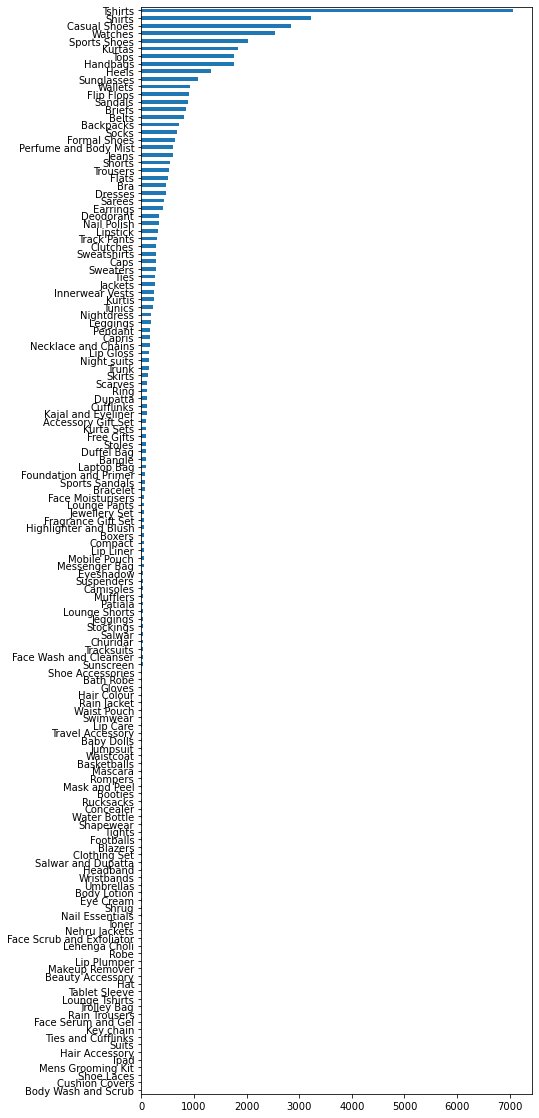

In [5]:
plt.figure(figsize=(7,20))
df.articleType.value_counts().sort_values().plot(kind='barh')

**Creating a new dataset**

For ease of use in the later sections (loading images using pytorchs **Dataset** and **Dataloader** modules) we will create a our own sub dataset out of the original one.

We will choose items with at least 250 images (150 for training and 100 for validation tasks) in the original dataset.

In [6]:
N_Pictures = 250
N_Classes = np.sum(df.articleType.value_counts().to_numpy() > N_Pictures)
#Number of classes with sufficient images to train on:
N_Classes

37

As we can see there is 37 item types with the sufficient number of images. So essentially we have 37x150=**5550** images for training and 37x100=**3700** images for validation tasks.

In [7]:
#Inspecting the item classes that made it to our new dataset
temp = df.articleType.value_counts().sort_values(ascending=False)[:N_Classes]
temp[-5:]

Sweatshirts    285
Caps           283
Sweaters       277
Ties           263
Jackets        258
Name: articleType, dtype: int64

In [8]:
#Saving item types(labels) with their counts
items_count = temp.values
items_label = temp.index.tolist()

In [9]:
#Creating new dataframes for training/validation
df_train = pd.DataFrame(columns=['articleType','image'])
df_val   = pd.DataFrame(columns=['articleType','image'])


for ii in range(0,N_Classes):
    
    #print(items_label[ii])
    
    temp = df[df.articleType==items_label[ii]].sample(N_Pictures)

    df_train = pd.concat([df_train, temp[ :int(N_Pictures*0.6) ][['articleType','image']] ]            , sort=False)
    df_val   = pd.concat([df_val,   temp[  int(N_Pictures*0.6): N_Pictures ][['articleType','image']] ], sort=False)

df_train.reset_index(drop=True)
df_val.reset_index(drop=True)

,articleType,image
0,Tshirts,6612.jpg
1,Tshirts,6586.jpg
2,Tshirts,7543.jpg
3,Tshirts,9963.jpg
4,Tshirts,16122.jpg
...,...,...
3695,Jackets,24135.jpg
3696,Jackets,15013.jpg
3697,Jackets,15323.jpg
3698,Jackets,15601.jpg


So let's create separate folders for every item type that has at least 250 images in the original dataset and store them there (a new subset). Separating them for **Trainig** and **Validation** tasks.

It will take around 10-15 min on the Kaggle's notebook.

In [10]:
#Create folders for new dataset
os.chdir(r'/kaggle/working/')
os.mkdir('data')
os.mkdir('data/train')
os.mkdir('data/val')
os.chdir(r'/kaggle/working/')

data = {'train': df_train, 'val': df_val}

# and save each individual image to the new directory
for x in ['train','val']:
    
    print(x)
    
    for label, file in data[x].values:
        
        try:
            img = Image.open(DATASET_PATH+'images/'+file)
        except FileNotFoundError:
            # If file does not exist continue
            continue
            
        #Else save file to new directory  
        try:
            img.save('data/'+x+'/'+label+'/'+file) 

        except FileNotFoundError:
            #If folder does not exist, create one and save the image
            os.mkdir('data/'+x+'/'+label)
            img.save('data/'+x+'/'+label+'/'+file)
            print(label,end=' ')
    

train
Tshirts Shirts Casual Shoes Watches Sports Shoes Kurtas Tops Handbags Heels Sunglasses Wallets Flip Flops Sandals Briefs Belts Backpacks Socks Formal Shoes Perfume and Body Mist Jeans Shorts Trousers Flats Bra Dresses Sarees Earrings Deodorant Nail Polish Lipstick Track Pants Clutches Sweatshirts Caps Sweaters Ties Jackets val
Tshirts Shirts Casual Shoes Watches Sports Shoes Kurtas Tops Handbags Heels Sunglasses Wallets Flip Flops Sandals Briefs Belts Backpacks Socks Formal Shoes Perfume and Body Mist Jeans Shorts Trousers Flats Bra Dresses Sarees Earrings Deodorant Nail Polish Lipstick Track Pants Clutches Sweatshirts Caps Sweaters Ties Jackets 

In [11]:
#Inspect if all the folders have been created
%ls data/train/

 Backpacks/       Flats/          'Perfume and Body Mist'/   Ties/
 Belts/          'Flip Flops'/     Sandals/                  Tops/
 Bra/            'Formal Shoes'/   Sarees/                  'Track Pants'/
 Briefs/          Handbags/        Shirts/                   Trousers/
 Caps/            Heels/           Shorts/                   Tshirts/
'Casual Shoes'/   Jackets/         Socks/                    Wallets/
 Clutches/        Jeans/          'Sports Shoes'/            Watches/
 Deodorant/       Kurtas/          Sunglasses/
 Dresses/         Lipstick/        Sweaters/
 Earrings/       'Nail Polish'/    Sweatshirts/


### Loading the New Dataset

We will use **torch.utils.data** packages ( *Dasatest* and *Dataloaders*) to load the new subset. We also need to transform our images into 224x224 px resolution and normalize the chanel values (the colors) suitable for the ResNet architecture. It can be easily done by exploiting the **torchvision.transforms** module.

In [12]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        #transforms.RandomResizedCrop(224),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Visualize a few images

#### Let’s visualize a few training images so as to understand the data augmentations.

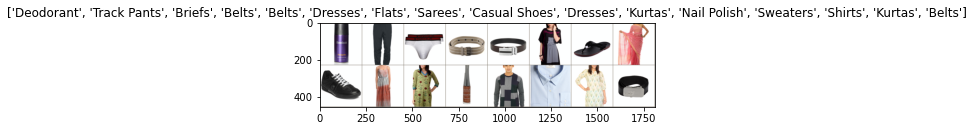

In [13]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Training the model <a name="training"></a>

Lets define our iterative learning process as a function with nested loops(epochs) inside:

In [14]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

### Visualizing the model predictions

#### Generic function to display predictions for a few images

In [99]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

### Finetuning the convnet

#### Load a pretrained model and reset final fully connected layer.

In [16]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

#Changing the number of outputs in the last layer to the number of different item types
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


**Train and evaluate**

It will take about 30-40 min to go through 6 epoch (using GPU).

In [17]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=5)

Epoch 0/4
----------
train Loss: 1.3080 Acc: 0.6739
val Loss: 0.5251 Acc: 0.8305

Epoch 1/4
----------
train Loss: 0.4472 Acc: 0.8659
val Loss: 0.4104 Acc: 0.8589

Epoch 2/4
----------
train Loss: 0.3262 Acc: 0.8993
val Loss: 0.3645 Acc: 0.8783

Epoch 3/4
----------
train Loss: 0.2477 Acc: 0.9274
val Loss: 0.3461 Acc: 0.8883

Epoch 4/4
----------
train Loss: 0.1885 Acc: 0.9445
val Loss: 0.3322 Acc: 0.8932

Training complete in 30m 34s
Best val Acc: 0.893214


\*\* As we can see, the model started to overfit after epoch number 3 ( the accuracy gain after each epoch on the validation dataset is miniscule compared to the training). The best validation accuracy is 0.893 (it could be improve by increasing the size of the training data).

In [18]:
#Saving our model's weights: 

%mkdir model
torch.save(model_ft.state_dict(), 'model/model_fine_tuned.pt')
%ls 

#Download the model weights and save them locally
from IPython.display import FileLink
FileLink(r'model/model_fine_tuned.pt')

__notebook_source__.ipynb  data/  model/


/kaggle/working/model/model_fine_tuned.pt

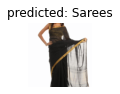

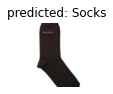

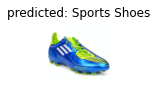

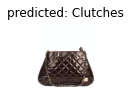

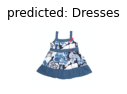

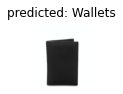

In [100]:
visualize_model(model_ft)

### ConvNet as fixed feature extractor:

In [20]:
model_conv = torchvision.models.resnet18(pretrained=True)
# Freezing the weights
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, len(class_names))

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

**Train and evaluate**

It will take about 40+ min to go through 15 epoch (using GPU).

In [21]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=15)

Epoch 0/14
----------
train Loss: 1.9894 Acc: 0.5378
val Loss: 0.9918 Acc: 0.7629

Epoch 1/14
----------
train Loss: 0.9447 Acc: 0.7705
val Loss: 0.7241 Acc: 0.7951

Epoch 2/14
----------
train Loss: 0.7226 Acc: 0.8114
val Loss: 0.6371 Acc: 0.8070

Epoch 3/14
----------
train Loss: 0.6301 Acc: 0.8323
val Loss: 0.5906 Acc: 0.8099

Epoch 4/14
----------
train Loss: 0.5720 Acc: 0.8431
val Loss: 0.5496 Acc: 0.8327

Epoch 5/14
----------
train Loss: 0.5362 Acc: 0.8472
val Loss: 0.5326 Acc: 0.8335

Epoch 6/14
----------
train Loss: 0.5070 Acc: 0.8521
val Loss: 0.5178 Acc: 0.8351

Epoch 7/14
----------
train Loss: 0.4778 Acc: 0.8699
val Loss: 0.5105 Acc: 0.8375

Epoch 8/14
----------
train Loss: 0.4647 Acc: 0.8694
val Loss: 0.5093 Acc: 0.8367

Epoch 9/14
----------
train Loss: 0.4746 Acc: 0.8649
val Loss: 0.5007 Acc: 0.8397

Epoch 10/14
----------
train Loss: 0.4752 Acc: 0.8668
val Loss: 0.5071 Acc: 0.8364

Epoch 11/14
----------
train Loss: 0.4630 Acc: 0.8683
val Loss: 0.5009 Acc: 0.8408

Ep

\*\* We can see, that the accuracy of this method saturates in the range of 0.87 for the training and 0.84 for the validation datasets. This limitation is a consequence of freezing the feature extraction part of our model and just rellying on the optimization of the classifier part.

In such a case we will use the former model instead (trained by finetuning all the weights).

In [25]:
#Saving our model's weights: 

%mkdir model
torch.save(model_conv.state_dict(), 'model/model_fixed_feature.pt')
%ls model/

from IPython.display import FileLink
FileLink(r'model/model_fixed_feature.pt')

model_fine_tuned.pt  model_fixed_feature.pt


/kaggle/working/model/model_fixed_feature.pt

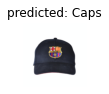

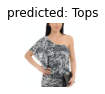

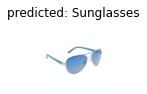

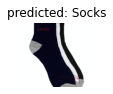

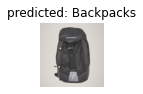

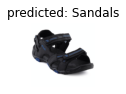

In [23]:
visualize_model(model_conv)

plt.ioff()
plt.show()

## Testing on different kind of images  <a name="introduction"></a>

Let's test our model on diferent kind of images (for example those with a colorfull background).

In [101]:
import shutil
import requests

%mkdir test_data

#Download the images from internet:
urls = [r'https://media.karousell.com/media/photos/products/2017/02/19/bnib_ecco_formal_shoes_brown_1487494013_3659d7da.jpg',
        r'https://17pprhpagc13i5210btdmqmf-wpengine.netdna-ssl.com/wp-content/uploads/2020/06/wallets-vegancom.jpg',
        r'https://www.tudorwatch.com/-/media/model-assets/wrist/l/tudor-m79030n-0001.jpg',
        r'https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/gettyimages-1256162242.jpg?crop=0.889xw:1.00xh;0,0&resize=640:*',
        r'https://cdn.shopify.com/s/files/1/0285/2916/4420/products/P8501_20PORTER_20JEAN_20MODEL_20_D_1024x1024.jpg?v=1584339217',
        r'https://images1.novica.net/pictures/26/p350363_2.jpg',
        r'https://cdn.shopify.com/s/files/1/0021/6331/0691/products/DP0423HS_43ddebc5-5e53-4dd6-af00-76ff2970bbd2_grande.jpg?v=1586232410',
        r'https://goodhousekeeping.fetcha.co.za/wp-content/uploads/2019/03/sweat.jpg',
        r'https://sneakernews.com/wp-content/uploads/2020/08/undefeated-kobe-5-protro-gold-purple-DA6809-700-3.jpg']

for ii, url in enumerate(urls):
    response = requests.get(url, stream=True)
    with open('test_data/img_test_' + str(ii) + '.jpg', 'wb') as out_file:
        shutil.copyfileobj(response.raw, out_file)
    del response
    
%ls test_data

mkdir: cannot create directory ‘test_data’: File exists
img_test_0.jpg  img_test_2.jpg  img_test_4.jpg  img_test_6.jpg  img_test_8.jpg
img_test_1.jpg  img_test_3.jpg  img_test_5.jpg  img_test_7.jpg


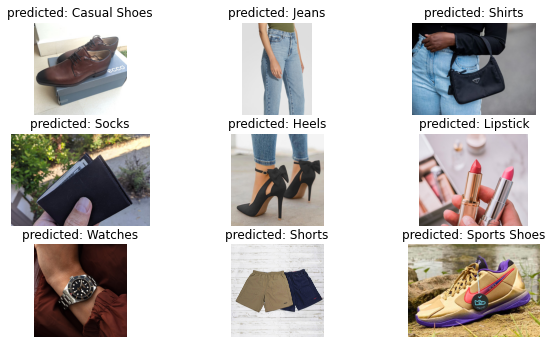

In [102]:
from PIL import Image

model = model_ft


model.eval()
fig = plt.figure(figsize=(10,18))

with torch.no_grad():

    for ii, file_name in enumerate(os.listdir( 'test_data' )):
        img = Image.open( 'test_data' + '/' + file_name)
        img_t = data_transforms['val'](img).unsqueeze(0)
        img_t = img_t.to(device)

        outputs = model(img_t)
        _, preds = torch.max(outputs, 1)
        
        ax = plt.subplot(len(os.listdir( 'test_data' )),3, ii+1)
        ax.axis('off')
        ax.set_title('predicted: {}'.format(class_names[int(preds.cpu().numpy())]))
        plt.imshow( np.array(img) )
        

**As we can see our model correctly described 7 out of 9 images not included in the dataset (with other than white background). Not bad at all**

## Useful links <a name="links"></a>


* [A Gentle Introduction to Transfer Learning for Deep Learning](https://machinelearningmastery.com/transfer-learning-for-deep-learning/)
* [A Comprehensive Hands-on Guide to Transfer Learning with Real-World Applications in Deep Learning](https://towardsdatascience.com/a-comprehensive-hands-on-guide-to-transfer-learning-with-real-world-applications-in-deep-learning-212bf3b2f27a)
* [Pytorch's official transfer learning tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)
